# Global setting

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# load dataset

In [2]:
import gzip
import json

import numpy as np
from tqdm import tqdm


dataset_path = '../data/troy.jl.gz'

with gzip.open(dataset_path) as json_file:
    json_dicts = np.array([json.loads(line) for line in json_file])
    dataset = [[jd['file_name'],
                jd['table_id'],
                np.array(jd['table_array']),
                jd['aggregation_annotations'],
                np.array(['annotations'])
                ]
                for jd in tqdm(json_dicts)]

100%|██████████| 200/200 [00:00<00:00, 5770.64it/s]


In [3]:
def normalize_number(value):
    pass

# Statistics

In [4]:
ds_list = []

aggregatee_group_count = 0
for file in dataset:
    file_name = file[0]
    table_id = file[1]
    aggr_annotations = file[3]
    if not aggr_annotations:
        continue
    for annotation in aggr_annotations:
        error_bound = annotation['error_bound']
        aggregatee_indices = annotation['aggregatee_indices']
        aggregator_index = annotation['aggregator_index']
        operator = annotation['operator']
        value = file[2][aggregator_index[0]][aggregator_index[1]]
        for aggregatee_index in aggregatee_indices:
            ds_list.append([file_name, table_id, value, str(aggregator_index), str(aggregatee_index), operator, error_bound, aggregatee_group_count])
        aggregatee_group_count += 1

In [5]:
import pandas

df = pandas.DataFrame(data=ds_list, columns=['file_name', 'sheet_name', 'value', 'aggregator_index', 'aggregatee_index', 'operator', 'error_bound', 'aggregatee_group'])

In [6]:
df

,file_name,sheet_name,value,aggregator_index,aggregatee_index,operator,error_bound,aggregatee_group
0,C10001,C10001,-3 970,"[8, 6]","[8, 4]",Subtract,1.0,0
1,C10001,C10001,-3 970,"[8, 6]","[8, 5]",Subtract,1.0,0
2,C10001,C10001,-22 689,"[6, 3]","[6, 1]",Subtract,1.0,1
3,C10001,C10001,-22 689,"[6, 3]","[6, 2]",Subtract,1.0,1
4,C10001,C10001,-25 819,"[5, 3]","[5, 6]",Sum,1.0,2
...,...,...,...,...,...,...,...,...
13228,C10199,C10199,2354.8,"[5, 5]","[5, 4]",Sum,0.0,2892
13229,C10199,C10199,4602.9,"[40, 5]","[40, 1]",Sum,0.0,2893
13230,C10199,C10199,4602.9,"[40, 5]","[40, 2]",Sum,0.0,2893
13231,C10199,C10199,4602.9,"[40, 5]","[40, 3]",Sum,0.0,2893


# Distribution of operators in all aggregation relations

# How many times a cell is used as aggregator?

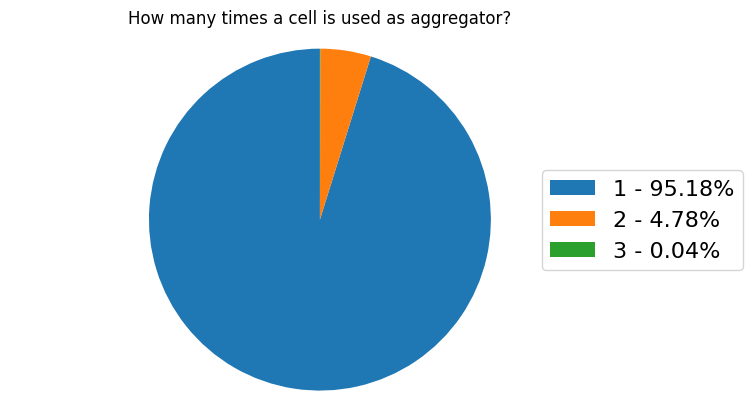

In [7]:
groups = df.groupby(['file_name', 'sheet_name', 'aggregator_index'])['aggregatee_group'].nunique()

unique_counts = np.unique(groups, return_counts=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
used_times = unique_counts[0]
count = unique_counts[1]

percentage = 100.*count/count.sum()
labels = ['{0} - {1:.2f}%'.format(i, j) for i, j in zip(used_times, percentage)]

fig, ax1 = plt.subplots()
ax1.pie(count, radius=1.2, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('How many times a cell is used as aggregator?')

plt.legend(labels, loc='center right', bbox_to_anchor=(1.2,0.5), fontsize=16)

plt.show()

# How many times a cell is used as aggregatee?

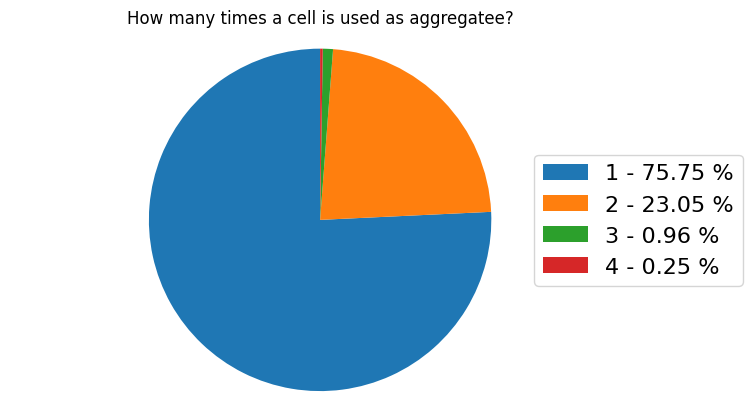

In [8]:
groups = df.groupby(['file_name', 'sheet_name', 'aggregatee_index']).size().reset_index(name='counts')

unique_counts = np.unique(groups['counts'], return_counts=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
used_times = unique_counts[0]
count = unique_counts[1]

fig, ax1 = plt.subplots()
ax1.pie(count, radius=1.2, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('How many times a cell is used as aggregatee?')

percentage = 100.*count/count.sum()
labels = ['{0} - {1:.2f} %'.format(i, j) for i, j in zip(used_times, percentage)]

plt.legend(labels, loc='center right', bbox_to_anchor=(1.2,0.5), fontsize=16)

plt.show()

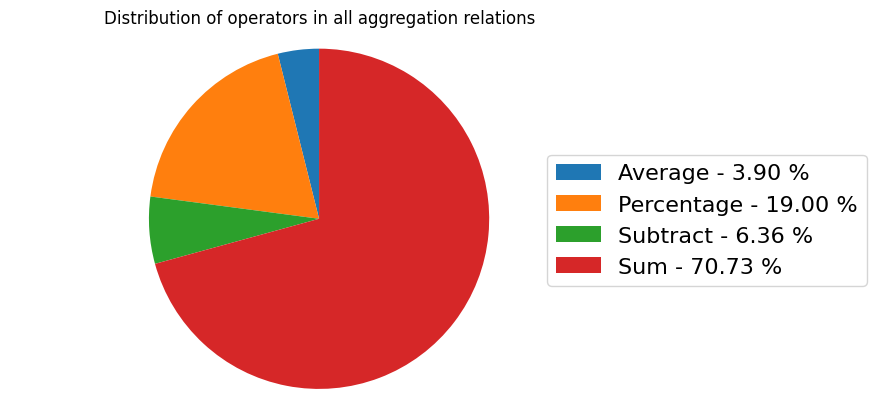

In [9]:
groups = df.groupby(['aggregatee_group', 'operator'])

keys = [key[1] for key, _ in groups]

unique_counts = np.unique(keys, return_counts=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
used_times = unique_counts[0]
count = unique_counts[1]

fig, ax1 = plt.subplots()
ax1.pie(count, radius=1.2, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribution of operators in all aggregation relations')

percentage = 100.*count/count.sum()
labels = ['{0} - {1:.2f} %'.format(i, j) for i, j in zip(used_times, percentage)]

plt.legend(labels, loc='center right', bbox_to_anchor=(1.4,0.5), fontsize=16)

plt.show()

In [10]:
unique_counts

(array(['Average', 'Percentage', 'Subtract', 'Sum'], dtype='<U10'),
 array([ 113,  550,  184, 2047]))

# How many aggregations are hopping?

In [11]:
groups = df.groupby(['aggregatee_group'])

import ast

hopping_distribution = {}

for name, group in groups:
    is_hopping = True
    for index, row in group.iterrows():
        operator = row['operator']
        aggor = ast.literal_eval(row['aggregator_index'])
        aggee = ast.literal_eval(row['aggregatee_index'])
        if aggee[0] == aggor[0] + 1 or aggee[0] == aggor[0] - 1 or aggee[1] == aggor[1] + 1 or aggee[1] == aggor[1] - 1:
            is_hopping = False
            break
    if operator not in hopping_distribution:
        hopping_distribution[operator] = [0, 0]
    if is_hopping:
        hopping_distribution[operator][0] += 1 
    else:
        hopping_distribution[operator][1] += 1

hopping_distribution

{'Subtract': [75, 109],
 'Sum': [279, 1768],
 'Percentage': [197, 353],
 'Average': [0, 113]}

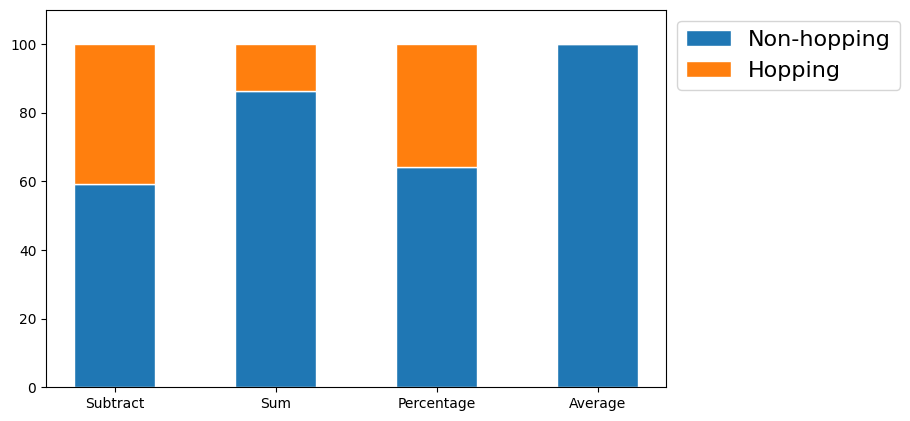

In [12]:
fig, ax1 = plt.subplots()
# Data
r = [*hopping_distribution.keys()]
raw_data = {'Non-hopping': [value[1] for _, value in hopping_distribution.items()], 'Hopping': [value[0] for _, value in hopping_distribution.items()]}
df = pandas.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i + j for i,j in zip(df['Non-hopping'], df['Hopping'])]
non_hopping = [i / j * 100 for i,j in zip(df['Non-hopping'], totals)]
hopping = [i / j * 100 for i,j in zip(df['Hopping'], totals)]
 
# plot
barWidth = 0.5
names = tuple(r)
# Create green Bars
ax1.bar(r, non_hopping, edgecolor='white', width=barWidth, label='Non-hopping')
# Create orange Bars
ax1.bar(r, hopping, bottom=non_hopping, edgecolor='white', width=barWidth, label='Hopping')
ax1.set_ylim([0, 110])
 
# Custom x axis
plt.xticks(r, names)

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=16)
 
# Show graphic
plt.show()


# Correlation between aggregator and aggregation keywords

In [13]:
ds_list = []

aggregatee_group_count = 0
for file in dataset:
    file_name = file[0]
    table_id = file[1]
    file_value = file[2]
    aggr_annotations = file[3]
    if not aggr_annotations:
        continue
    for annotation in aggr_annotations:
        error_bound = annotation['error_bound']
        aggregatee_indices = annotation['aggregatee_indices']
        aggregator_index = annotation['aggregator_index']
        operator = annotation['operator']
        value = file[2][aggregator_index[0]][aggregator_index[1]]
        row_values = file_value[aggregator_index[0]]
        column_values = [row[aggregator_index[1]] for row in file_value]
        
        ds_list.append([file_name, table_id, value, str(aggregator_index), str(aggregatee_indices), operator, error_bound, row_values, column_values, aggregatee_group_count])
        
df = pandas.DataFrame(data=ds_list, columns=['file_name', 'sheet_name', 'value', 'aggregator_index', 'aggregatee_indices', 'operator', 'error_bound', 'row_values', 'column_values', 'aggregatee_group'])

In [14]:
df['aggregator_index']

0        [8, 6]
1        [6, 3]
2        [5, 3]
3        [6, 3]
4        [3, 1]
         ...   
2889     [4, 5]
2890    [23, 5]
2891    [57, 5]
2892     [5, 5]
2893    [40, 5]
Name: aggregator_index, Length: 2894, dtype: object

In [15]:
def hasKeywords(kw_list, value_tokens):
    contained_kws = set.intersection(set(kw_list), set(map(lambda x:x.lower(), value_tokens)))
    if contained_kws:
        return True
    else:
        return False

In [16]:
sum_kw_list = ['total', 'all', 'sum']
average_kw_list = ['average']
percentage_kw_list = ['percentage', 'percent', 'increase']
subtract_kw_list = ['difference', 'diff', 'minus']

import itertools
from nltk.tokenize import word_tokenize

kw_distribution = {}

for index, row in df.iterrows():
    aggor_index = ast.literal_eval(row['aggregator_index'])
    aggee_indices = ast.literal_eval(row['aggregatee_indices'])
    column_values = row['column_values']
    row_values = row['row_values']
    if aggor_index[0] == aggee_indices[0][0]:
        all_words = list(itertools.chain(*[word_tokenize(value) for value in column_values]))
    elif aggor_index[1] == aggee_indices[0][1]:
        all_words = list(itertools.chain(*[word_tokenize(value) for value in row_values]))
    else:
        continue
    
    operator = row['operator']
    if operator == 'Sum':
        aggr_kw_list = sum_kw_list
    elif operator == 'Average':
        aggr_kw_list = average_kw_list
    elif operator == 'Percentage':
        aggr_kw_list = percentage_kw_list
    elif operator == 'Subtract':
        aggr_kw_list = subtract_kw_list
    else:
        aggr_kw_list = []
    
    contained_kws = set.intersection(set(aggr_kw_list), set(map(lambda x:x.lower(), all_words)))
    
    if operator not in kw_distribution:
        kw_distribution[operator] = [0, 0]
    if contained_kws:
        kw_distribution[operator][0] += 1 
    else:
        kw_distribution[operator][1] += 1

In [17]:
# first item: has keywords
kw_distribution

{'Subtract': [0, 184],
 'Sum': [1145, 902],
 'Percentage': [166, 384],
 'Average': [0, 113]}

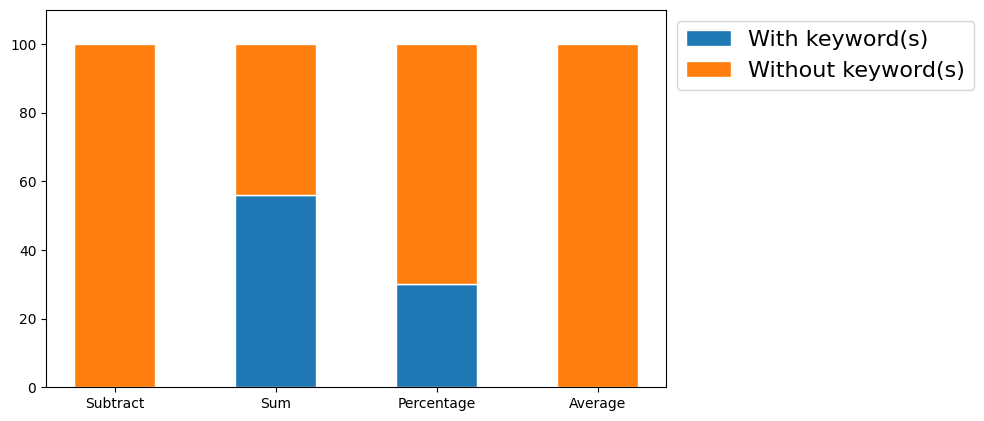

In [18]:
fig, ax1 = plt.subplots()
# Data
r = [*kw_distribution.keys()]
raw_data = {'With keyword(s)': [value[0] for _, value in kw_distribution.items()], 'Without keyword(s)': [value[1] for _, value in kw_distribution.items()]}
df = pandas.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i + j for i,j in zip(df['With keyword(s)'], df['Without keyword(s)'])]
w_kw = [i / j * 100 for i,j in zip(df['With keyword(s)'], totals)]
wo_kw = [i / j * 100 for i,j in zip(df['Without keyword(s)'], totals)]

# plot
barWidth = 0.5
names = tuple(r)
# Create green Bars
ax1.bar(r, w_kw, edgecolor='white', width=barWidth, label='With keyword(s)')
# Create orange Bars
ax1.bar(r, wo_kw, bottom=w_kw, edgecolor='white', width=barWidth, label='Without keyword(s)')
ax1.set_ylim([0, 110])
 
# Custom x axis
plt.xticks(r, names)

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=16)
 
# Show graphic
plt.show()

In [97]:
ds_list = []

aggregatee_group_count = 0
for file in dataset:
    file_name = file[0]
    table_id = file[1]
    file_value = file[2]
    aggr_annotations = file[3]
    if not aggr_annotations:
        continue
    for annotation in aggr_annotations:
        error_bound = annotation['error_bound']
        aggregatee_indices = annotation['aggregatee_indices']
        aggregator_row_index = annotation['aggregator_index'][0]
        aggregator_column_index = annotation['aggregator_index'][1]
        operator = annotation['operator']
        value = file[2][aggregator_row_index][aggregator_column_index]
     
        ds_list.append([file_name, table_id, value, aggregator_row_index, aggregator_column_index, str(aggregatee_indices), operator, error_bound, aggregatee_group_count])
        
df = pandas.DataFrame(data=ds_list, columns=['file_name', 'sheet_name', 'value', 'aggregator_row_index', 'aggregator_column_index', 'aggregatee_indices', 'operator', 'error_bound', 'aggregatee_group'])

In [98]:
df

,file_name,sheet_name,value,aggregator_row_index,aggregator_column_index,aggregatee_indices,operator,error_bound,aggregatee_group
0,C10001,C10001,-21 139,3,3,"[[3, 2], [3, 1]]",Subtract,0.0,0
1,C10001,C10001,853,3,18,"[[3, 16], [3, 17]]",Subtract,0.0,0
2,C10001,C10001,-5 450,6,6,"[[6, 5], [6, 4]]",Subtract,0.0,0
3,C10001,C10001,-17 064,9,3,"[[9, 1], [9, 2]]",Subtract,0.0,0
4,C10001,C10001,-3 682,9,6,"[[9, 4], [9, 5]]",Subtract,0.0,0
...,...,...,...,...,...,...,...,...,...
2768,C10199,C10199,2183.9,4,5,"[[4, 1], [4, 2], [4, 3], [4, 4]]",Sum,0.0,0
2769,C10199,C10199,3920.5,23,5,"[[23, 1], [23, 2], [23, 3], [23, 4]]",Sum,0.0,0
2770,C10199,C10199,5820.6,57,5,"[[57, 1], [57, 2], [57, 3], [57, 4]]",Sum,0.0,0
2771,C10199,C10199,2354.8,5,5,"[[5, 1], [5, 2], [5, 3], [5, 4]]",Sum,0.0,0


In [99]:
kw_distribution = {}

for file in dataset:
    value_array = file[2]
    file_name = file[0]
    sheet_name = file[1]
    for i in range(len(value_array)):
        all_words = list(itertools.chain(*[word_tokenize(value) for value in value_array[i]]))
        if hasKeywords(sum_kw_list, all_words):
            operator = 'Sum'
        elif hasKeywords(subtract_kw_list, all_words):
            operator = 'Subtract'
        elif hasKeywords(average_kw_list, all_words):
            operator = 'Average'
        elif hasKeywords(percentage_kw_list, all_words):
            operator = 'Percentage'
        filtered_df = df[(df['file_name'] == file_name) & (df['sheet_name'] == sheet_name) & (df['aggregator_row_index'] == i) & (df['operator'] == operator)]
        if operator not in kw_distribution:
            kw_distribution[operator] = [0, 0]
        if len(filtered_df) > 0:
            kw_distribution[operator][0] += 1 
        else:
            kw_distribution[operator][1] += 1
            
    for i in range(len(value_array[0])):
        column_values = [value[i] for value in value_array]
        all_words = list(itertools.chain(*[word_tokenize(value) for value in column_values]))
        if hasKeywords(sum_kw_list, all_words):
            operator = 'Sum'
        elif hasKeywords(subtract_kw_list, all_words):
            operator = 'Subtract'
        elif hasKeywords(average_kw_list, all_words):
            operator = 'Average'
        elif hasKeywords(percentage_kw_list, all_words):
            operator = 'Percentage'
        filtered_df = df[(df['file_name'] == file_name) & (df['sheet_name'] == sheet_name) & (df['aggregator_row_index'] == i) & (df['operator'] == operator)]
        if operator not in kw_distribution:
            kw_distribution[operator] = [0, 0]
        if len(filtered_df) > 0:
            kw_distribution[operator][0] += 1 
        else:
            kw_distribution[operator][1] += 1                

In [100]:
# first item: has kw, has aggregator
kw_distribution

{'Sum': [1119, 5728],
 'Subtract': [0, 8],
 'Average': [12, 198],
 'Percentage': [66, 235]}

# Distribution of number of hierarchies in left/top attributes

In [101]:
# load troy dataset ground truth
input_path = '/Users/lan/Documents/hpi/projects/hierarchical-structure-detection/data/TabbyXL Experiment Data/data/gt'

import glob

import os
file_path_pattern = os.path.join(input_path, '*.xlsx')

import pandas

file_left_attr_hierarchy_arr = []
file_top_attr_hierarchy_arr = []
for file in sorted(glob.glob(file_path_pattern)):
    sheet = pandas.read_excel(file, header=0, sheet_name='CANONICAL TABLE')
    num_hierarchies_all_left = sheet['RowHeading1'].apply(lambda value: len(str(value).split('|')))
    num_hierarchies_all_top = sheet['ColumnHeading'].apply(lambda value: len(str(value).split('|')))
    max_num_hierarchy_left = max(num_hierarchies_all_left)
    max_num_hierarchy_top = max(num_hierarchies_all_top)
    file_left_attr_hierarchy_arr.append([file, max_num_hierarchy_left])
    file_top_attr_hierarchy_arr.append([file, max_num_hierarchy_top])

flah_df = pandas.DataFrame(file_left_attr_hierarchy_arr, columns=['File', 'Hierarchy Depth'])
ftah_df = pandas.DataFrame(file_top_attr_hierarchy_arr, columns=['File', 'Hierarchy Depth'])

In [102]:
groups_hierarchy_depth_left = flah_df.groupby(['Hierarchy Depth']).count().reset_index()
groups_hierarchy_depth_top = ftah_df.groupby(['Hierarchy Depth']).count().reset_index()

/Users/lan/miniconda3/envs/aggrdet/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  del sys.path[0]
/Users/lan/miniconda3/envs/aggrdet/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


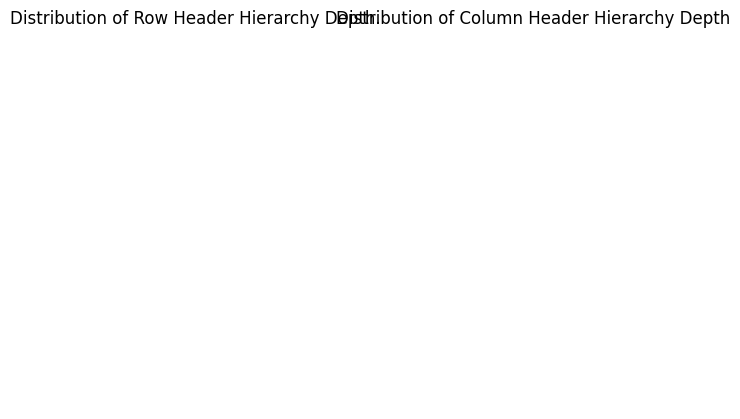

In [103]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
hierarchy_depth_left = groups_hierarchy_depth_left['Hierarchy Depth']
count_left = groups_hierarchy_depth_left['File']

hierarchy_depth_top = groups_hierarchy_depth_top['Hierarchy Depth']
count_top = groups_hierarchy_depth_top['File']

# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(count_left, labels=hierarchy_depth_left, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribution of Row Header Hierarchy Depth.')

ax2.pie(count_top, labels=hierarchy_depth_top, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Distribution of Column Header Hierarchy Depth')

plt.show()

# Distribution of Operators (Add, Subtract, Average, Percentage)

In [104]:
input_path = '/Users/lan/Documents/hpi/projects/hierarchical-structure-detection/experiments/operator-distribution.csv'

sheet = pandas.read_csv(input_path, header=0)

sheet

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lan/Documents/hpi/projects/hierarchical-structure-detection/experiments/operator-distribution.csv'